In [1]:
import networkx as nx
import torch.nn as nn
import torch
import torch.optim as optim
import numpy as np
import scipy.sparse as sp
import matplotlib.pyplot as plt
from sklearn.metrics.pairwise import cosine_similarity
import time
import pickle
from collections import OrderedDict, deque
from nervenet import NerveNet_GNN
from copy import deepcopy
import random

device = torch.device("cuda" if torch.cuda.is_available() else "cpu")

In [2]:
# https://discuss.pytorch.org/t/clone-and-detach-in-v0-4-0/16861/2

# List of things todo
- ~~Add Double DQN and make sure vanilla DQN formula is correct~~
- ~~Need to track the grads and detach the grads for outputs that arent a part of the actual minibatch fit~~
- ~~Debug multiple props~~
- ~~Track the grad for multiple props~~
- Go through "https://pytorch.org/tutorials/intermediate/reinforcement_q_learning.html"
- After going through ^ see if i need to change my loss because i think that I need to reshape or something so that the vector is summed and then meaned which means that the mean does nothing since there is only one sample per train anyway
- Also make sure to add huber loss
- Add dikstras to get optimal path from init to goal and use this both as reward and to limit the the path length in an ep
- check if adding cuda actually made it slower
- once i tune this a bit see if .new_tensor() instead of .clone() works better
- Try instead of looping through for each prop, expliclty unrolling each prop to make sure that replacing the var node states isnt an issue

## Grab data and make Graph

In [3]:
class Page:
    def __init__(self, text, links):
        self.text = text
        self.links = links  # out-links
        self.in_links = []
        self.indx = None  # Relative to the ordered dict below
        self.feats = None

In [4]:
# Load the wiki-dict i want
with open('data/animals-D3-small-30K-nodes40-edges202-max10-minout2-minin3_w_features.pkl', 'rb') as f:
    pages = pickle.load(f)

In [5]:
# Convert to ordered dict so i can use indices to refer to pages
# Convert pages to ordered dict
pages = OrderedDict(pages)
# Add indices and get feats for each page
node_feats = []
for indx, (title, obj) in enumerate(pages.items()):
    obj.indx = indx
    node_feats.append(obj.feats)
node_feats = np.stack(node_feats)

In [6]:
# Make edges for graph generation
edges = []
for title, obj in pages.items():
    for link in obj.links:
        in_node = obj.indx
        out_node = pages[link].indx
        edges.append((in_node, out_node))

In [7]:
# Make whole graph
G_whole = nx.DiGraph()
G_whole.add_edges_from(edges)

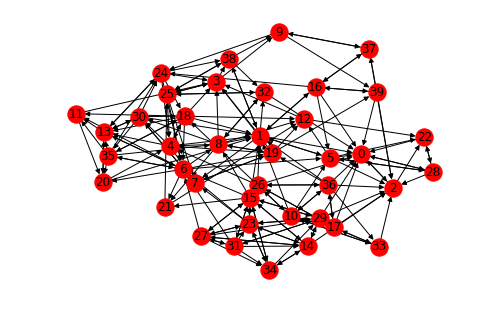

In [8]:
nx.draw_kamada_kawai(G_whole, with_labels=True)
plt.show()

### Constants

In [9]:
# Episode Constants
num_eps = 3
max_ep_steps = 50
ignore_internal_nodes = True
num_props = 3  # number of propogations per step

In [10]:
# Data/Model Constants
num_nodes = len(pages)
num_edges = len(edges)  # Only needed for deepmind
node_feat_size = node_feats.shape[1]
edge_feat_size = ...  # Only needed for deepmind
node_hidden_size = 64  
edge_hidden_size = ...  # Only needed for deepmind
message_size = 32  # Only for nervenet
output_size = 1

In [11]:
# Goal Constants
# there are three ways im testing, 
# 1)if i put it in the state update func
# 2) if I send it in to the output i.e. after the update 
# 3) If i dont send in the goal and do a cos sim test between the output and the goal
goal_opt = 2
# Another option is whether to put the goal through the input layer or not
goal_input_layer = True
if goal_input_layer:
    goal_size = node_hidden_size
else:
    goal_size = node_feat_size

In [12]:
# Agent Constans
mem_max_size = 100000
init_eps = 1.0
final_eps = 0.1
final_exp_step = 200
target_update_freq = 50  # in overall steps
train_freq = 4  # in overall steps
double_dqn = True
minibatch_size = 32
gamma = 0.95
learning_rate = 1e-2

## DQN Agent

In [13]:
def cos_sim(a, b):
    return cosine_similarity(a, b)[:, 0]

In [14]:
# For now this is -1 per timestep +5 on terminal for reaching goal, -5 on terminal for not reaching goal
# In future, i want to give it feedback on how close it got by either:
# 1) For all nodes (or edge nodes) calc the shortest distance to the goal and then pick the shortest and use that
# 2) If (1) takes too long than instead embed all of the found nodes names and pick the one with the closest dist to
# the goal embedding to use
def reward_func(terminal, reach_goal):
    rew = -1
    if terminal:
        rew += 5 if reach_goal else -5
    return rew

In [15]:
class DQNAgent:
    def __init__(self):
        self.memory  = deque(maxlen=mem_max_size)
        self.eps = init_eps
        # Make behavior gnn and target gnn
        self.gnn = NerveNet_GNN(node_feat_size, node_hidden_size, message_size, output_size, goal_size, goal_opt, device).to(device)
        self.gnn_ = NerveNet_GNN(node_feat_size, node_hidden_size, message_size, output_size, goal_size, goal_opt, device).to(device)
        self.optimizer = optim.Adam(self.gnn.parameters(), lr=learning_rate)
        
    # train_step is overall train step (not just per ep)
    def update_implicit_policy(self, train_step):
        if train_step <= final_exp_step:
            self.eps = final_eps + (init_eps - final_eps) * np.maximum(0, (final_exp_step - train_step)) / final_exp_step
    
    def remember(self, mem_tuple):
        self.memory.append(mem_tuple)
#         mem = self.memory[-1]
#         state, action, reward, next_state, done = mem[0], mem[1], mem[2], mem[3], mem[4]
#         print('State::')
#         print('num nodes: {}  goal_feats: {}  G_curr nodes: {}  current nodes: {}'.format(state['num_nodes'], state['goal_feats'], state['G_curr'].nodes, state['current_nodes']))

#         print('Action::'+str(action))

#         print('Reward::'+str(reward))

#         print('Next State::')
#         print('num nodes: {}  goal_feats: {}  G_curr nodes: {}  current nodes: {}'.format(next_state['num_nodes'], next_state['goal_feats'], next_state['G_curr'].nodes, next_state['current_nodes']))

        
    # act (eps-greedy)
    def select_node(self, outputs):
        # Explore
        if random.random() < self.eps:
            action = random.randint(0, outputs.shape[0]-1)
        else:
            action = outputs.argmax()
        return action
    
    # TODO: See if soft-update improves performance
    def update_target_models(self):
        self.gnn_.input_model = deepcopy(self.gnn.input_model)
        self.gnn_.message_model = deepcopy(self.gnn.message_model)
        self.gnn_.update_model = deepcopy(self.gnn.update_model)
        self.gnn_.output_model = deepcopy(self.gnn.output_model)
    
    # DEBUG -----------
    def print_memory(self):
        for mem in self.memory:
            state, action, reward, next_state, done = mem[0], mem[1], mem[2], mem[3], mem[4]
            print('State::')
            print('num nodes: {}  goal_feats: {}  G_curr nodes: {}  current nodes: {}'.format(state['num_nodes'], state['goal_feats'], state['G_curr'].nodes, state['current_nodes']))
            
            print('Action::'+str(action))
            
            print('Reward::'+str(reward))
            
            print('Next State::')
            print('num nodes: {}  goal_feats: {}  G_curr nodes: {}  current nodes: {}'.format(next_state['num_nodes'], next_state['goal_feats'], next_state['G_curr'].nodes, next_state['current_nodes']))
            
    # ------------------
    
    # TODO: Figure out how to optimize this and _fit to run multiple graphs/states at once
    def train(self):
        # Sample a minibatch of memory tuples
        minibatch = random.sample(self.memory, minibatch_size)
        states, actions, targets = [], [], []
        for state, action, reward, next_state, done in minibatch:
            target = reward
            if not done:
                if not double_dqn:
                    outputs = propogate(self.gnn_, next_state).detach().cpu().numpy()  # Detach grad
                    target = reward + gamma * outputs.max()
                else:
                    outputs_beh = propogate(self.gnn, next_state).detach().cpu().numpy()
                    next_state_action = np.argmax(outputs_beh)
                    outputs_tar = propogate(self.gnn_, next_state).detach().cpu().numpy()
                    outputs_tar_action_val = outputs_tar[next_state_action]
                    target = reward + gamma * outputs_tar_action_val
            states.append(state)
            actions.append(action)
            targets.append(target)
            
        loss = self._fit(states, actions, targets)
#         print('loss: {}'.format(loss))
        return loss
        
    # Does the actual optimization
    def _fit(self, states, actions, targets):
        losses = []
        for s, a, t in zip(states, actions, targets):
#             print('-----')
            self.optimizer.zero_grad()
            outputs = propogate(self.gnn, s)
#             print('outputs {}'.format(outputs))
            targets = outputs.clone()
#             print('targets {}'.format(targets))
            targets[a] = t
#             print('a {}'.format(a))
#             print('t {}'.format(t))
#             print('targets {}'.format(targets))
            loss = self.gnn.backward(outputs, targets)
#             print('lo {}'.format(loss))
            self.optimizer.step()
            losses.append(loss)
        return np.array(losses).mean()

## Run It

In [16]:
# node_indx is the same indx as G_curr and G_whole
def add_children(G_curr, node_indx, goal_node_indx, current_nodes):
    achieved_goal = False
    # Check the children of the node to see if they need to be added to the current graph
    children = G_whole.successors(node_indx)
    for child in children:
        # Add child if not in G and check if goal
        if child not in G_curr:
            G_curr.add_node(child)
            current_nodes.update({child: len(current_nodes)})
            if child == goal_node_indx:
                achieved_goal = True
        # If the edge doesnt exist add it
        if not G_curr.has_edge(node_indx, child):
            G_curr.add_edge(node_indx, child)
    assert sorted(list(current_nodes.values())) == list(current_nodes.values())
    return achieved_goal

In [17]:
def initialize_ep():
    # Pick init node and add its children
#     init_node = 5  # rel to the whole graph
    init_node = random.randint(0, num_nodes-1)
    # Pick goal node
#     goal_node = 10
    goal_node = random.randint(0, num_nodes-1)
    
    # restart if goal node is init node
    if init_node == goal_node:
        initialize_ep()
    
    # Get goal feats
    goal_feats = node_feats[goal_node]
    assert goal_feats.shape == (node_feat_size,)
    # Make init graph
    G_init = nx.DiGraph()
    G_init.add_node(init_node)
    current_nodes = OrderedDict({init_node: 0})  # Init current nodes dict
    got_goal = add_children(G_init, init_node, goal_node, current_nodes)
#     print(current_nodes.values())
#     print(sorted(list(current_nodes.values())))
    assert sorted(list(current_nodes.values())) == list(current_nodes.values())
    
    # Restart if goal_node directly leads to the goal
    if got_goal:
        initialize_ep()
    
    return G_init, current_nodes, goal_node, goal_feats

In [18]:
# current_nodes: ordereddict with keys as abs node indices, values as rel node indices (rel to the ordered dict)
def get_predecessors(G_curr, current_nodes):
    all_preds = []  # List of lists
    for node in current_nodes.keys():
        preds_abs = G_curr.predecessors(node)  # abs to all nodes, keys to the dict
        preds_rel = [current_nodes[x] for x in preds_abs]
        all_preds.append(preds_rel)
    return all_preds  # Returns a list of lists with the values being tth rel node indices

In [31]:
def propogate(gnn, state):
    num_nodes, goal_feats, G_curr, current_nodes = state['num_nodes'], state['goal_feats'], state['G_curr'], state['current_nodes']
    node_feats_tensor = torch.tensor(node_feats, device=device, requires_grad=True, dtype=torch.float)
    goal_feats_tensor = torch.tensor(goal_feats, device=device, requires_grad=True, dtype=torch.float)
    # Grab the feats of the nodes in the current graph
    node_states = node_feats_tensor[list(current_nodes.keys())] 
    # If goal_input_layer is True then embed the goal by sending it into the input layer
    if goal_input_layer:
        goal_embeddings = gnn.input_model(goal_feats_tensor.reshape(1, -1)).flatten()
        stacked_goal_embeds = torch.stack([goal_embeddings] * num_nodes)
    else:
        stacked_goal_embeds = torch.stack([goal_feats_tensor] * num_nodes)
    for p in range(num_props):
        predecessors = get_predecessors(G_curr, current_nodes)
        node_states, outputs = gnn(node_states, p == 0, p == num_props-1, predecessors, stacked_goal_embeds)
        assert node_states.shape == (num_nodes, node_hidden_size)
    assert outputs.flatten().shape == (num_nodes,)
    return outputs.flatten()

In [28]:
# Deep copy everything before it goes into a state
def make_state(current_nodes, goal_feats, G_curr):
    current_nodes_copy = current_nodes.copy()
    goal_feats_copy = goal_feats
    G_curr_copy = G_curr.copy()
    return {'num_nodes': len(current_nodes_copy), 'goal_feats': goal_feats_copy, 'G_curr': G_curr_copy, 'current_nodes': current_nodes_copy}

In [29]:
def run_episode(ep, total_step):
    # Init. the episode graph and current nodes
    G_curr, current_nodes, goal_node, goal_feats = initialize_ep()
    assert len(current_nodes) > 1
    ep_rew = 0
    ep_losses = []
    state = make_state(current_nodes, goal_feats, G_curr)
    for step in range(max_ep_steps):
#         print ('------------')
        
        # Pick node to explore by propogating -- Take Action --
        outputs = propogate(agent.gnn, state).detach().cpu().numpy()
        selected_node_rel = agent.select_node(outputs)
        selected_node_abs = list(current_nodes.keys())[selected_node_rel]
        
        # Debug ---
#         print('STATE PRE COPY')
#         print('num nodes: {}  goal_feats: {}  G_curr nodes: {}  current nodes: {}'.format(state['num_nodes'], state['goal_feats'], state['G_curr'].nodes, state['current_nodes']))
#         print('\n')
        # ---------
        
        # TODO: Check that this actually deep copies eveythign so that the graph/current nodes in state dont change below
        state = deepcopy(state)

        # Add the children -- Run env forward a step --
        achieved_goal = add_children(G_curr, selected_node_abs, goal_node, current_nodes)
        # Done if goal found or end of ep
        done = True if (step == max_ep_steps - 1) or achieved_goal  else False
        rew = reward_func(done, achieved_goal)
        ep_rew += rew

        # Add to agent memory pool
        next_state = make_state(current_nodes, goal_feats, G_curr)
        
        # TODO: REMEMBER THAT I AM SENDONG IN THE RELATIVE NODE AS THE ACTION! CHECK THIS
        memory_tuple = (state, selected_node_rel, rew, next_state, done)
        agent.remember(memory_tuple)
        
         # Debug ---
#         print('STATE After COPY')
#         print('num nodes: {}  goal_feats: {}  G_curr nodes: {}  current nodes: {}'.format(state['num_nodes'], state['goal_feats'], state['G_curr'].nodes, state['current_nodes']))
#         print('\n')
        # ---------
        
        state = deepcopy(next_state)
        
        # Debug ---
#         print('NEXT STATE')
#         print('num nodes: {}  goal_feats: {}  G_curr nodes: {}  current nodes: {}'.format(next_state['num_nodes'], next_state['goal_feats'], next_state['G_curr'].nodes, next_state['current_nodes']))
#         print('\n')
        # ---------
        
        # Update eps-greedy policy
        agent.update_implicit_policy(total_step)
        
        # Update target model if necc
        if total_step % target_update_freq == 0 and total_step != 0:
            agent.update_target_models()
            
        # Train if necc
        if total_step % train_freq == 0 and total_step != 0 and len(agent.memory) >= minibatch_size:
#             print('step: {}'.format(total_step))
#             print('mem: {}'.format(len(agent.memory)))
            mb_loss = agent.train()
            ep_losses.append(mb_loss)
        
        total_step += 1
        if done:
            break
#     agent.print_memory()
    
    print('Episode {}  Epsilon: {:2f}  Mem. size: {}  Avg loss: {:3f}  Reward: {}  Achieved goal: {}  Num steps: {}'.format(ep+1, agent.eps, len(agent.memory), np.array(ep_losses).mean(), ep_rew, achieved_goal, step+1))
    
    return total_step
    

In [32]:
agent = DQNAgent()
total_step = 0
for ep in range(num_eps):
    total_step = run_episode(ep, total_step)
plt.show()

Episode 1  Epsilon: 1.000000  Mem. size: 1  Avg loss: nan  Reward: 4  Achieved goal: True  Num steps: 1
Episode 2  Epsilon: 0.914500  Mem. size: 20  Avg loss: nan  Reward: -14  Achieved goal: True  Num steps: 19
Episode 3  Epsilon: 0.865000  Mem. size: 31  Avg loss: nan  Reward: -6  Achieved goal: True  Num steps: 11


/Users/mbrenner/anaconda3/lib/python3.7/site-packages/ipykernel_launcher.py:72: RuntimeWarning: Mean of empty slice.
